In [3]:
import pytimber as pt
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.optimize as opt
from scipy.special import erf
from scipy.stats import norm

from matplotlib.ticker import FixedLocator
import matplotlib


#is_swan = False
#if is_swan == False:
#    from nxcals.spark_session_builder import get_or_create
#    from nxcals.api.extraction.data.builders import DataQuery
#    spark = get_or_create("My_APP")

In [4]:
print(spark.conf.get("spark.sql.parquet.columnarReaderBatchSize"))
spark.conf.set("spark.sql.parquet.columnarReaderBatchSize", "4")
print(spark.conf.get("spark.sql.parquet.columnarReaderBatchSize"))

25/06/20 18:53:05 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@74d6d08d{/SQL,null,AVAILABLE,@Spark}
25/06/20 18:53:05 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3527c1f8{/SQL/json,null,AVAILABLE,@Spark}
25/06/20 18:53:05 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@7117c13a{/SQL/execution,null,AVAILABLE,@Spark}
25/06/20 18:53:05 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@36ace3a5{/SQL/execution/json,null,AVAILABLE,@Spark}
25/06/20 18:53:05 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@5d4a3e3e{/static/sql,null,AVAILABLE,@Spark}
4096
4


In [51]:
print(spark.conf.get("spark.sql.parquet.enableNestedColumnVectorizedReader"))
spark.conf.set("spark.sql.parquet.enableNestedColumnVectorizedReader", "false")
print(spark.conf.get("spark.sql.parquet.enableNestedColumnVectorizedReader"))

false
false


In [5]:
def datestring_to_timestamp_utc(date_string):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S') - timedelta(hours=2)
    
    # Convert the datetime object to UTC timezone if it's not already in UTC
    if date_obj.tzinfo is None or date_obj.tzinfo.utcoffset(date_obj) is None:
        date_obj = date_obj.replace(tzinfo=timezone.utc)
    else:
        date_obj = date_obj.astimezone(timezone.utc)
    
    # Extract the timestamp in seconds
    timestamp_utc = date_obj.timestamp()
    
    return timestamp_utc


def utc_timestamp_to_date_string(timestamp):
    # Convert the timestamp to a datetime object in UTC
    utc_datetime = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    
    # Format the datetime object to a string
    date_string = utc_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    return date_string

In [6]:
lbd = pt.LoggingDB(source='nxcals', spark_session=spark)

In [58]:
ti = '2025-05-13 22:58:40'
tf = '2025-05-13 22:59:40'

#var = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
var = "hitMapTFT"

In [59]:
fromTimber = lbd.get(var, ti, tf)

In [60]:
fromTimber

{'hitMapTFT': (array([1.74716992e+09]),
  [array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=int32)])}

In [61]:
len(fromTimber['hitMapTFT'][0])

1

In [62]:
test = fromTimber['hitMapTFT'][1][0]
test.shape

(1500, 1500)

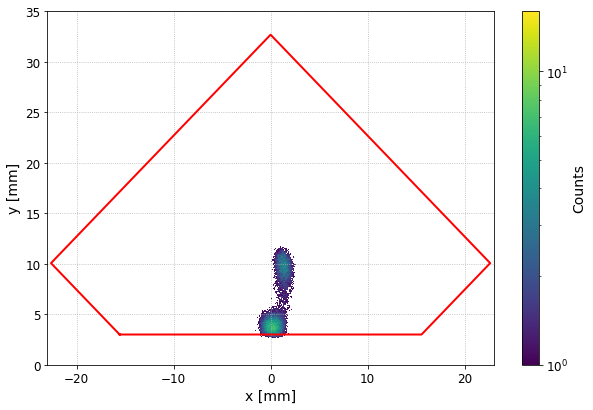

In [63]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots(figsize=(10,6.5))
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(test, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [64]:
test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
def plot_Tracks(time, comulative = False, y_lower=None, y_upper=None, absolute_y_pos= 0, plot_fit = False,
                z_max_2D = None, z_max_y = None, z_max_x = None,  normalize = False, print_info = False):
    
    values, edges_x, edges_y = get_tracks(time, comulative)
    if values is None:
        return
    
    edges_y = edges_y + absolute_y_pos
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax[0][0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, vmax=z_max_2D)  
    ALFA_x, ALFA_y = get_pentagonal(absolute_y_pos*1e-3+0.003)
    ax[0][0].plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    cbar = plt.colorbar(pcm, ax=ax[0][0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0][0].set_xlabel("x [mm]", fontsize=14)
    ax[0][0].set_ylabel("y [mm]", fontsize=14)
    ax[0][0].tick_params(axis='both', which='major', labelsize=12)
    ax[0][0].grid(linestyle=":")
    max_value = np.max(masked_values)
    bin_width_x = np.diff(edges_x)[0]  # Assuming uniform bin widths
    bin_width_y = np.diff(edges_y)[0]  # Assuming uniform bin widths

    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour f"{h:02d}:{m:02d}"
    if comulative:
        hour = 13
        minute = 17
    ax[0][0].text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax[0][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    #values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection = np.sum(values, axis=0) 
    bin_centers_y = (edges_y[:-1] + edges_y[1:]) / 2
    ax[0][1].bar(edges_y[:-1], y_projection, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[0][1].set_xlabel("y [mm]", fontsize=14)
    ax[0][1].set_ylabel("Counts", fontsize=14)
    ax[0][1].tick_params(axis='both', which='major', labelsize=12)
    if z_max_y is not None:
        ax[0][1].set_ylim(0, z_max_y)

    x_projection = np.sum(values, axis=1)  # sum over y → projection along x
    bin_centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])  # Compute bin centers
    ax[1][0].bar(edges_x[:-1], x_projection, width=np.diff(edges_x), align="edge", alpha=0.6)
    ax[1][0].set_xlabel("x [mm]", fontsize=14)
    ax[1][0].set_ylabel("Counts", fontsize=14)
    ax[1][0].tick_params(axis='both', which='major', labelsize=12)
    if z_max_x is not None:
        ax[1][0].set_ylim(0, z_max_x)

    if print_info:
        print("Maximum value in the bins:", max_value)
        print("Bin width along y-axis:", bin_width_y)
        print("Bin width along x-axis:", bin_width_x)
        print("Maximum in x projection:", np.max(x_projection))
        print("Maximum in y projection:", np.max(y_projection))


    cumulative_y_projection = np.cumsum(np.array(y_projection)[::-1])[::-1]
    if normalize:
        cumulative_y_projection = cumulative_y_projection / np.max(cumulative_y_projection)
    ax[1][1].plot(edges_y[:-1], cumulative_y_projection, linewidth=2, label="Cumulative Y Projection")
    ax[1][1].tick_params(axis='both', which='major', labelsize=12)

    if y_lower is not None and y_upper is not None:

        # Filter in y
        y_mask = (bin_centers_y >= y_lower) & (bin_centers_y <= y_upper)
        values_filtered = values[:, y_mask] 
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]
        y_centers_filt = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])
        y_projection_filt = np.sum(values_filtered, axis=0)  # Sum over x-axis
        x_projection_filt = np.sum(values_filtered, axis=1)  # Sum over y-axis
        ax[0][0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0][0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Create a 2D meshgrid
        X, Y = np.meshgrid(bin_centers_x, y_centers_filt, indexing="ij")  # Ensure correct shape
        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]
        # Fit the 2D Gaussian function
        initial_guess = (np.max(zdata), np.mean(x_projection_filt), np.mean(y_projection_filt), np.std(x_projection_filt), np.std(x_projection_filt))
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"2D Gauss Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")
        #ax[0][0].plot(x0_fit, y0_fit, "ro", markersize=10, label="Fit center")

        # Compute Y Projection 
        y_fit = np.linspace(np.min(y_centers_filt), np.max(y_centers_filt), 100)
        gaussian_curve_y = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  #
        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral_y = np.sum(y_projection_filt * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral_y = np.trapz(gaussian_curve_y, y_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_y = hist_integral_y / gaussian_integral_y  # Rescale amplitude properly
        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve_y = gaussian_1d(y_fit, A_rescaled_y, y0_fit, sigma_y_fit)
        ax[0][1].plot(y_fit, gaussian_curve_y, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        ax[0][1].axvline(y_upper)
        ax[0][1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm\nFit sigma: {sigma_y_fit:.2f} mm"
        ax[0][1].text(0.75, 0.95, legend_text, ha="right", va="top", transform=ax[0][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        # Compute X fit 
        x_fit = np.linspace(np.min(bin_centers_x), np.max(bin_centers_x), 100)
        gaussian_curve_x = gaussian_1d(x_fit, 1, x0_fit, sigma_x_fit)  #
        hist_integral_x = np.sum(x_projection_filt * np.diff(edges_x))
        gaussian_integral_x = np.trapz(gaussian_curve_x, x_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_x = hist_integral_x / gaussian_integral_x  # Rescale amplitude properly
        gaussian_curve_x = gaussian_1d(x_fit, A_rescaled_x, x0_fit, sigma_x_fit)
        ax[1][0].plot(x_fit, gaussian_curve_x, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        legend_text = f"Fit mean: {x0_fit:.2f} mm\nFit sigma: {sigma_x_fit:.2f} mm"
        ax[1][0].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        ax[1][1].axvline(y_lower, color="red", linestyle="--", label="Mean")
        cum_to_fit_erf = cumulative_y_projection[edges_y[:-1] >= y_lower]
        y_to_fit_erf = edges_y[:-1][edges_y[:-1] >= y_lower]
        def erfunc(x,a,b,c,d):
            return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
        
        param0 = [np.max(cum_to_fit_erf), np.min(cum_to_fit_erf), np.mean(y_to_fit_erf), np.std(y_to_fit_erf)]
        params, extras = opt.curve_fit(erfunc, y_to_fit_erf, cum_to_fit_erf,  p0=param0)
        print("ERF Fit parameters:", params)
        ax[1][1].plot(edges_y[:-1], erfunc(edges_y[:-1], *params), linewidth=2, label="ERF Fit")
        legend_text = f"Fit mean: {params[2]:.2f} mm\nFit sigma: {params[3]:.2f} mm"
        ax[1][1].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
        
        if plot_fit:
            ax[0][0].plot(popt[1], popt[2], 'ro', markersize=2, label='Gaussian Fit Center')
            ellipse = matplotlib.patches.Ellipse((popt[1], popt[2]), width=6*popt[3], height=6*popt[4],
                                                    edgecolor='g', facecolor='none', linewidth=2, zorder=4)
            ax[0][0].add_patch(ellipse)

In [59]:
# Assuming test is your 2D array
ny, nx = test.shape

# Calculate bin sizes
dx = (xlim[1] - xlim[0]) / nx
dy = (ylim[1] - ylim[0]) / ny

print(f"Bin size in x direction: {dx} mm")
print(f"Bin size in y direction: {dy} mm")

Bin size in x direction: 0.030666666666666665 mm
Bin size in y direction: 0.023333333333333334 mm


In [47]:
nx

1500

512


In [33]:
ti = '2025-05-15 18:21:00'
tf = '2025-05-15 18:22:00'

#var = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
var = "hitMapTFT"

In [34]:
fromTimber = lbd.get(var, ti, tf)

In [ ]:
"""for i in fromTimber['hitMapTFT'][0]:
    print(utc_timestamp_to_date_string(i))"""

In [35]:
data = np.array(fromTimber['hitMapTFT'][1])

In [36]:
TFT_data_to_plot = np.sum(data, axis =0)

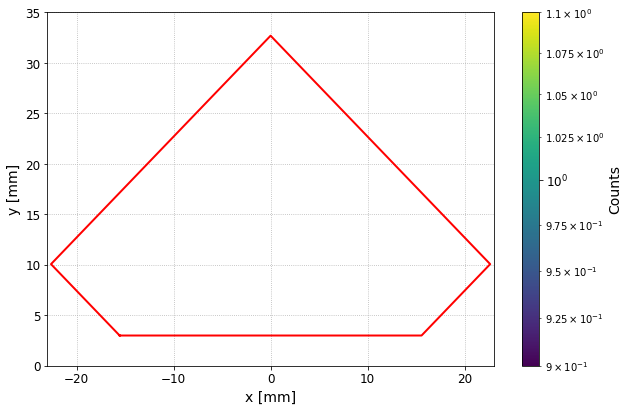

In [37]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots(figsize=(10,6.5))
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(TFT_data_to_plot, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [24]:
import pytimber as pt

lbd = pt.LoggingDB(source='nxcals', spark_session=spark)
ti = '2025-05-15 18:32:00'
tf = '2025-05-15 18:33:00'

#var = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
var = "hitMapPix"
fromTimber_PIX = lbd.get(var, ti, tf)

In [11]:
fromTimber_PIX = lbd.get(var, ti, tf)

In [25]:
len(fromTimber_PIX["hitMapPix"][0])

160

In [26]:
data_PIX = np.array(fromTimber_PIX["hitMapPix"][1])

In [27]:
data_PIX.shape

(160, 768, 256)

In [28]:
PIX_data_to_plot = np.sum(data_PIX, axis =0)

In [29]:
PIX_data_to_plot.shape

(768, 256)

In [30]:
21.45*2 /14.30

2.9999999999999996

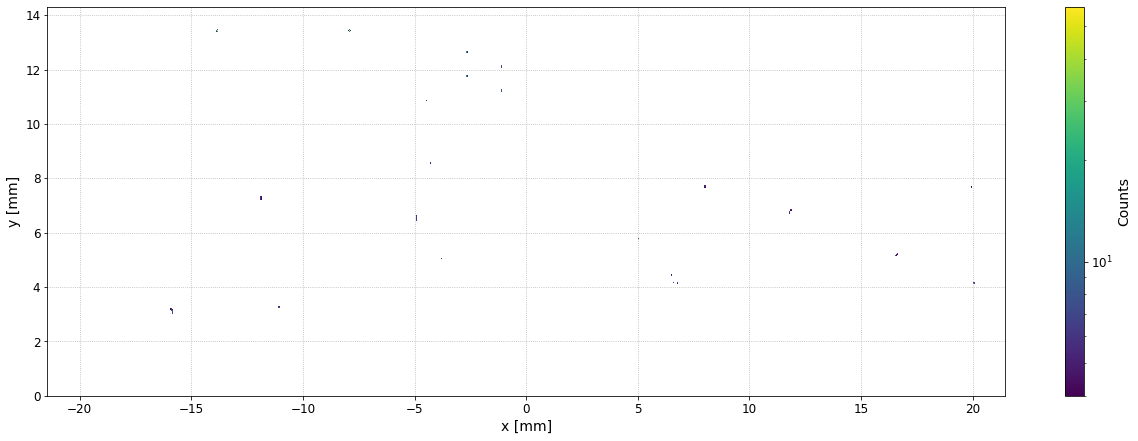

In [60]:
fig, ax = plt.subplots(figsize=(21.45,14.30/2))
xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [32]:
np.sum(PIX_data_to_plot)

465